<a href="https://colab.research.google.com/github/appliedcode/mthree-c422/blob/mthree-c422-dipti/Exercises/NLP-Assignments/NLP_Team_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets transformers evaluate scikit-learn

# 1. Import libraries
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
import numpy as np
import evaluate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.6 MB/s eta 0:00:00


In [2]:
# 2. Load dataset
dataset = load_dataset("yelp_polarity")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/256M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/560000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/38000 [00:00<?, ? examples/s]

In [3]:
# 3. Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [4]:
# 4. Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/560000 [00:00<?, ? examples/s]

Map:   0%|          | 0/38000 [00:00<?, ? examples/s]

In [5]:
# 5. Prepare for PyTorch
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

train_dataset = tokenized_datasets["train"]
test_dataset = tokenized_datasets["test"]

In [6]:
# 6. Load model (BERT for binary classification)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# 7. Define evaluation metrics
accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"],
        "precision": precision.compute(predictions=predictions, references=labels, average="binary")["precision"],
        "recall": recall.compute(predictions=predictions, references=labels, average="binary")["recall"],
        "f1": f1.compute(predictions=predictions, references=labels, average="binary")["f1"]
    }


In [15]:
# 8. Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=0.02,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    report_to="none" # Disable wandb integration
)

In [16]:
# 9. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset.shuffle(seed=42).select(range(20000)),  # smaller subset for faster training
    eval_dataset=test_dataset.select(range(50)),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# 10. Train the model
trainer.train()

/tmp/ipython-input-4197793204.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,0.060500,0.344358,0.920000,0.920000,0.920000,0.920000


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


TrainOutput(global_step=50, training_loss=0.06046653747558594, metrics={'train_runtime': 702.0691, 'train_samples_per_second': 0.57, 'train_steps_per_second': 0.071, 'total_flos': 26311105536000.0, 'train_loss': 0.06046653747558594, 'epoch': 0.02})

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



Evaluation Results: {'eval_loss': 0.3443581759929657, 'eval_accuracy': 0.92, 'eval_precision': 0.92, 'eval_recall': 0.92, 'eval_f1': 0.92, 'eval_runtime': 20.9184, 'eval_samples_per_second': 2.39, 'eval_steps_per_second': 0.335, 'epoch': 0.02}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


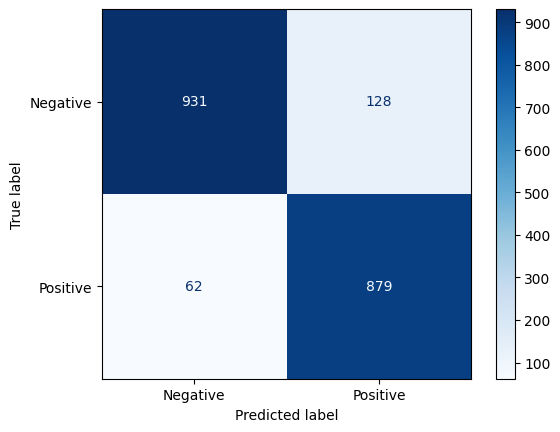

In [17]:
# 11. Evaluate the model
eval_results = trainer.evaluate()
print("\nEvaluation Results:", eval_results)

# 12. Confusion matrix
predictions = trainer.predict(test_dataset.select(range(2000)))
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.show()